In [1]:
"""
Optimized for Apple M2 Pro
"""
import os
import time
import pickle

import numpy as np
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
from functools import partial
import math
from scipy.spatial.transform import Rotation
import itertools

# Add src directory to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_dir = os.path.join(project_root, 'src')
sys.path.append(src_dir)

from spectra import sum_of_diracs, bispectrum

#------------------------------------------------------------------------------
# JAX & Hardware Configuration
#------------------------------------------------------------------------------

jax.config.update('jax_enable_x64', True)
jax.config.update('jax_platform_name', 'cpu')
jax.config.update('jax_default_matmul_precision', 'high')

#------------------------------------------------------------------------------
# Constants
#------------------------------------------------------------------------------

LMAX = 5
NUM_INITS = 20

#------------------------------------------------------------------------------
# Helpers
#------------------------------------------------------------------------------

def determine_optimal_batch_size() -> int:
    """Pick a default batch size: 8 on M1/M2 silicon, else 5."""
    try:
        import platform
        return 8 if platform.processor() == 'arm' else 5
    except:
        return 5

@jax.jit
def compute_bispectrum_for(env):
    """Compute bispectrum for an (M×3) array, zeros allowed."""
    return bispectrum(sum_of_diracs(env, LMAX))

@partial(jax.jit, static_argnums=(2,))
def invert_with_adam(true_bs, init_pts, num_iters=10000):
    """Adam-based inversion."""
    lr = 1e-2
    opt = optax.adam(lr)
    state = opt.init(init_pts)
    def loss_fn(x):
        pred_bs = bispectrum(sum_of_diracs(x, LMAX))
        return jnp.mean(jnp.abs(true_bs - pred_bs))
    def step(carry, _):
        pts, st = carry
        g = jax.grad(loss_fn)(pts)
        updates, st = opt.update(g, st, pts)
        return (optax.apply_updates(pts, updates), st), None
    (final_pts, _), _ = jax.lax.scan(step, (init_pts, state), None, length=num_iters)
    return final_pts

def stack_points(points: np.ndarray) -> jnp.ndarray:
    """
    Cluster points by alignment (cosine > 0.866), sum and threshold
    with half the max norm. Returns (K×3) JAX array or empty.
    """
    norms = np.linalg.norm(points, axis=1, keepdims=True)
    valid = norms[:,0] > 0
    pts = points.copy()
    pts[valid] /= norms[valid]
    D = pts @ pts.T
    used = np.ones(len(points),bool)
    clusters = []
    while used.any():
        i = np.argmax(used)
        aligned = (D[i] > 0.866) & used
        if not aligned.any(): break
        clusters.append(points[aligned].sum(0))
        used[aligned] = False
    if not clusters:
        return jnp.zeros((0,3), jnp.float64)
    C = np.stack(clusters)
    norms = np.linalg.norm(C, axis=1)
    thresh = 0.5 * norms.max()
    C = C[norms >= thresh]
    return jnp.array(C, jnp.float64)



def align_predicted_geometry(true_geometry: np.ndarray,
                             predicted_geometry: np.ndarray
                            ) -> tuple[np.ndarray, float]:
    """
    Aligns `predicted_geometry` onto `true_geometry` using only a rigid-body rotation.
    Points are first sorted by distance from the origin, normalized to unit radius,
    then each pair of corresponding direction‐vectors is scaled by a different
    random weight (to break any geometric symmetry) before computing the optimal
    rotation. Assumes both inputs are centered at the origin.

    Parameters
    ----------
    true_geometry : (N, 3) array_like
        Reference point cloud, centered at the origin.
    predicted_geometry : (N, 3) array_like
        Point cloud to align, also centered.

    Returns
    -------
    aligned_predicted : (N, 3) ndarray
        The `predicted_geometry` rotated to best match `true_geometry`.
    rmsd : float
        The RMSD between the (weighted) direction‐vectors after optimal alignment.
    """
    # Convert inputs
    true_pts = np.asarray(true_geometry, dtype=float)
    pred_pts = np.asarray(predicted_geometry, dtype=float)
    if true_pts.shape != pred_pts.shape or true_pts.shape[1] != 3:
        raise ValueError("Both inputs must have shape (N, 3)")

    # Compute norms (radii) without sorting
    true_radii = np.linalg.norm(true_pts, axis=1)
    pred_radii = np.linalg.norm(pred_pts, axis=1)
    
    # Normalize to unit vectors directly without reordering
    true_dirs = true_pts / true_radii[:, None]
    pred_dirs = pred_pts / pred_radii[:, None]    

    # Generate a different random weight for each point to break symmetry
    # (e.g. uniform on [0,1) or any other distribution)
    weights = np.random.rand(true_dirs.shape[0], 1)

    # Scale both sets by the same per-point weights
    true_weighted = true_dirs * weights
    pred_weighted = pred_dirs * weights

    # Compute optimal rotation on weighted directions
    rot, rmsd = Rotation.align_vectors(true_weighted, pred_weighted)

    # Apply rotation back to the original predicted points
    pred_rotated = rot.apply(pred_pts)

    return pred_rotated, rmsd


def alignment_mae(true_geometry, predicted_geometry):

    true_geometry = np.array(true_geometry)
    predicted_geometry = np.array(predicted_geometry)

    if true_geometry.shape != predicted_geometry.shape:
        return float('inf')

    # Try all permutations of the predicted geometry and select the one with lowest RMSD
    best_error = float('inf')
    best_aligned = None
    
    # Get all permutations of indices
    n_points = predicted_geometry.shape[0]
    for perm in itertools.permutations(range(n_points)):
        perm_predicted = predicted_geometry[list(perm)]
        aligned, _ = align_predicted_geometry(true_geometry, perm_predicted)
        error = jnp.mean(jnp.linalg.norm(aligned - true_geometry, axis=1))
        # error = np.mean(np.abs(aligned - true_geometry), axis=1)
        if error < best_error:
            best_error = error
            best_aligned = aligned

    return best_error, best_aligned

In [2]:
with open('../data/qm9_local_envs.pkl', 'rb') as f:
    local_envs = pickle.load(f)

In [3]:
len(local_envs)

1177631

In [4]:
with open('../data/qm9_local_envs_10000.pkl', 'rb') as f:
    local_envs = pickle.load(f)

local_envs = [jnp.array(local_env) for local_env in local_envs]
train_geometries = local_envs[:9900]
test_geometries = local_envs[9900:]

print(f"Number of local environments: {len(local_envs)}")

Number of local environments: 10000


In [5]:
bispectra = [compute_bispectrum_for(local_env) for local_env in local_envs]

train_bispectra = jnp.array(bispectra[:9900])
test_bispectra = jnp.array(bispectra[9900:])

In [ ]:
import jax
import jax.numpy as jnp
from jax import random, grad, jit
import flax.linen as nn
import optax
from flax.training import train_state
import numpy as np
from typing import Any, Dict
from functools import partial

# Set random seed for reproducibility
key = random.PRNGKey(42)

# Hyperparameters
input_dim = 22       # Length of bispectrum vectors
latent_dim = 6       # Dimension of the latent space
hidden_dim = 128     # Hidden layer dimension
batch_size = 256
learning_rate = 1e-3
num_epochs = 100

# Modified Autoencoder Model with separate encoder and decoder methods
class Autoencoder(nn.Module):
    hidden_dim: int
    latent_dim: int
    
    def setup(self):
        # Encoder layers
        self.encoder_layer1 = nn.Dense(self.hidden_dim)
        self.encoder_layer2 = nn.Dense(self.hidden_dim)
        self.encoder_output = nn.Dense(self.latent_dim)
        
        # Decoder layers
        self.decoder_layer1 = nn.Dense(self.hidden_dim)
        self.decoder_layer2 = nn.Dense(self.hidden_dim)
        self.decoder_output = nn.Dense(input_dim)
    
    def encode(self, x):
        x = self.encoder_layer1(x)
        x = nn.leaky_relu(x, negative_slope=0.2)
        x = self.encoder_layer2(x)
        x = nn.leaky_relu(x, negative_slope=0.2)
        return self.encoder_output(x)
    
    def decode(self, z):
        x = self.decoder_layer1(z)
        x = nn.leaky_relu(x, negative_slope=0.2)
        x = self.decoder_layer2(x)
        x = nn.leaky_relu(x, negative_slope=0.2)
        return self.decoder_output(x)
    
    def __call__(self, x):
        latent = self.encode(x)
        reconstructed = self.decode(latent)
        return reconstructed, latent

# Loss function (MSE only)
def loss_fn(params, batch, model):
    reconstructed, latent = model.apply({'params': params}, batch)
    
    # Reconstruction loss (MSE)
    recon_loss = jnp.mean(jnp.sum((reconstructed - batch) ** 2, axis=1))
    
    return recon_loss, recon_loss

# Create a non-JIT train step that we'll later partially apply with the model
def train_step_fn(model, state, batch):
    def loss_step(params):
        loss, recon_loss = loss_fn(params, batch, model)
        return loss, recon_loss
    
    grad_fn = jax.value_and_grad(loss_step, has_aux=True)
    (loss, recon_loss), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    
    return state, loss, recon_loss


# Prepare batches of data
def get_batches(data, batch_size, shuffle=True):
    num_samples = data.shape[0]
    indices = jnp.arange(num_samples)
    
    if shuffle:
        # Shuffle indices
        key = random.PRNGKey(0)
        indices = random.permutation(key, indices)
    
    # Create batches
    num_batches = num_samples // batch_size
    batches = []
    for i in range(num_batches):
        batch_indices = indices[i * batch_size:(i + 1) * batch_size]
        batches.append(data[batch_indices])
    
    return batches

# Main training function
def train_autoencoder(model, data, num_epochs, batch_size, learning_rate):
    # Initialize model parameters
    key = random.PRNGKey(0)
    dummy_input = jnp.ones((1, input_dim))
    params = model.init(key, dummy_input)['params']  # Extract only 'params'
    
    # Create optimizer
    tx = optax.adam(learning_rate)
    
    # Create training state (standard Flax training state without model)
    state = train_state.TrainState.create(
        apply_fn=None,  # Not needed since we use model.apply directly
        params=params,
        tx=tx
    )
    
    # Create a JIT-compiled step function by partially applying the model
    # This way the model is captured in the closure and isn't passed as a dynamic argument
    jitted_train_step = jit(partial(train_step_fn, model))
    
    # Prepare batches
    batches = get_batches(data, batch_size)
    
    # Training loop
    loss_history = {'total': [], 'recon': []}
    
    for epoch in range(num_epochs):
        epoch_loss, epoch_recon_loss = 0.0, 0.0
        
        for batch in batches:
            # Use the JIT-compiled function with the model already applied
            state, loss, recon_loss = jitted_train_step(state, batch)
            epoch_loss += loss
            epoch_recon_loss += recon_loss
        
        # Average losses
        avg_loss = epoch_loss / len(batches)
        avg_recon_loss = epoch_recon_loss / len(batches)
        
        # Record history
        loss_history['total'].append(float(avg_loss))
        loss_history['recon'].append(float(avg_recon_loss))
        
        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, '
                  f'Loss: {avg_loss}, '
                  f'Recon Loss: {avg_recon_loss}')
    
    return state, loss_history, model

# Function to encode data
def encode_data(params, data, model):
    """Encode data into the latent space"""
    # Use the encode method directly
    latent = model.apply({'params': params}, data, method=model.encode)
    return latent

# New function to decode latents
def decode_data(params, latents, model):
    """Decode latent vectors back to original space"""
    # Use the decode method directly
    reconstructed = model.apply({'params': params}, latents, method=model.decode)
    return reconstructed

# Create model
model = Autoencoder(hidden_dim=hidden_dim, latent_dim=latent_dim)

# Load or generate data
data = train_bispectra

print(f"Training Autoencoder with latent dimension {latent_dim}...")
state, loss_history, model = train_autoencoder(model, data, num_epochs, batch_size, learning_rate)

# Save model (using pickle or another method)
import pickle
with open('bispectrum_autoencoder_model.pkl', 'wb') as f:
    pickle.dump({'params': state.params, 'loss_history': loss_history}, f)

print("Training complete. Model saved as 'bispectrum_autoencoder_model.pkl'")

# Encode some examples to test
sample_data = data[:5]  # Get 5 samples
encoded_samples = encode_data(state.params, sample_data, model)
print("Example latent representations:")
print(encoded_samples)

# Decode the encoded samples to demonstrate round-trip
decoded_samples = decode_data(state.params, encoded_samples, model)
print("\nExample reconstructions (decoded from latents):")
print(decoded_samples)

# You can also generate new samples by creating custom latent vectors
custom_latent = jnp.array([[0.5, -0.3, 0.2, -0.1, 0.4, -0.2]])  # Custom latent vector
generated_sample = decode_data(state.params, custom_latent, model)
print("\nGenerated sample from custom latent vector:")
print(generated_sample)

Training Autoencoder with latent dimension 6...
Epoch 10/100, Loss: 0.0000, Recon Loss: 0.0000, KL Loss: 22.1284
Epoch 20/100, Loss: 0.0000, Recon Loss: 0.0000, KL Loss: 22.1553
Epoch 30/100, Loss: 0.0000, Recon Loss: 0.0000, KL Loss: 22.0877
Epoch 40/100, Loss: 0.0000, Recon Loss: 0.0000, KL Loss: 21.9935
Epoch 50/100, Loss: 0.0000, Recon Loss: 0.0000, KL Loss: 21.8324
Epoch 60/100, Loss: 0.0000, Recon Loss: 0.0000, KL Loss: 21.8129
Epoch 70/100, Loss: 0.0000, Recon Loss: 0.0000, KL Loss: 21.7867
Epoch 80/100, Loss: 0.0000, Recon Loss: 0.0000, KL Loss: 21.7398
Epoch 90/100, Loss: 0.0000, Recon Loss: 0.0000, KL Loss: 21.7292
Epoch 100/100, Loss: 0.0000, Recon Loss: 0.0000, KL Loss: 21.7225
Training complete. Model saved as 'bispectrum_autoencoder_model.pkl'
Example latent representations:
[[-0.02616252  0.01594419 -0.00608192  0.06756461 -0.04687863  0.01272844]
 [-0.0037332  -0.00208639  0.00672312  0.02336414 -0.00790731  0.00204731]
 [ 0.00155757 -0.00409256  0.0032242   0.00264847 

In [7]:
from tqdm import tqdm



def invert(bs):

    master_rng = jax.random.PRNGKey(0)

    best_loss = np.inf
    best_geometry = None

    for _ in range(5):
        # 1) split RNG, sample a fresh init
        master_rng, subkey = jax.random.split(master_rng)
        init_pts = jax.random.normal(subkey, (15,3), jnp.float64)

        # 2) first inversion
        final_pts = invert_with_adam(bs, init_pts, num_iters=2000)

        # 3) cluster the result
        stacked = stack_points(np.array(final_pts))

        # 4) second inversion on clustered points
        if stacked.shape[0] > 0:
            pred_geometry = invert_with_adam(bs, stacked, num_iters=3000)
            loss = np.mean(np.abs(compute_bispectrum_for(pred_geometry) - bs))
        else:
            loss = np.inf


        # 5) keep if best
        if loss < best_loss:
            best_loss = loss
            best_geometry = pred_geometry

    return best_geometry


def get_errors(geometries):
    bispectra = [compute_bispectrum_for(geometry) for geometry in geometries]
    encoded_samples = encode_data(state.params, bispectra, model)
    decoded_samples = decode_data(state.params, encoded_samples, model)
    errors = []
    for i in tqdm(range(len(decoded_samples))):
        reconstructed_geometry = invert(decoded_samples[i])
        errors.append(alignment_mae(geometries[i], reconstructed_geometry))
    return errors

results = get_errors(test_geometries)

  0%|          | 0/100 [00:07<?, ?it/s]


KeyboardInterrupt: 

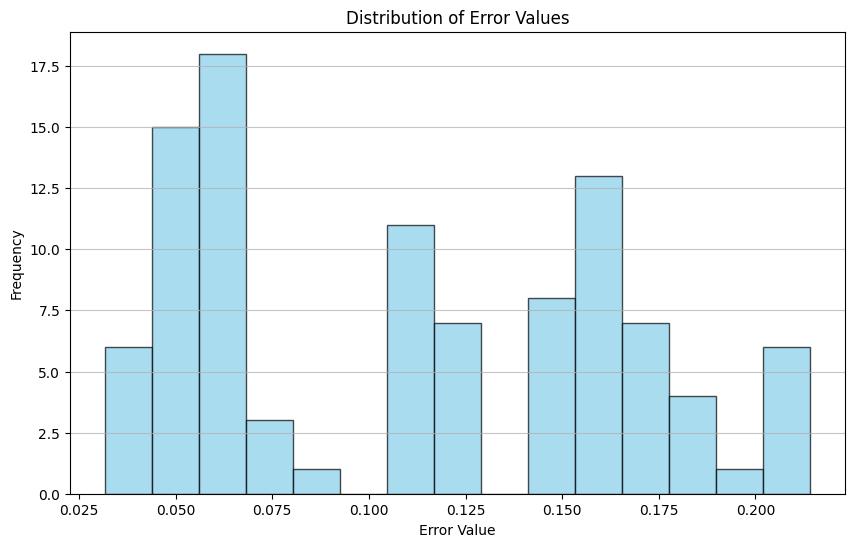

0.11116523170000002


In [11]:
import numpy as np
import matplotlib.pyplot as plt

values = np.array([
    0.20987744, 0.11993033, 0.04886378, 0.08389465, 0.12432294, 0.05274911,
    0.05273433, 0.1432002, 0.21241392, 0.05576259, 0.15021543, 0.12219436,
    0.04734997, 0.05767783, 0.14559012, 0.21034505, 0.06197981, 0.1148291,
    0.18482202, 0.03294464, 0.06262239, 0.1662191, 0.17612517, 0.04493244,
    0.16311735, 0.12186848, 0.05154655, 0.05968298, 0.1625936, 0.16930106,
    0.05393093, 0.11269089, 0.18969996, 0.03345822, 0.05515823, 0.15985629,
    0.14508923, 0.21404901, 0.05476685, 0.15976424, 0.05474266, 0.05687721,
    0.1613514, 0.11090523, 0.21065515, 0.06072422, 0.11857658, 0.04529459,
    0.05557662, 0.15961353, 0.15654611, 0.14431164, 0.06220401, 0.16493175,
    0.03685311, 0.05582264, 0.15870771, 0.10616933, 0.17534231, 0.06130252,
    0.16681183, 0.05992527, 0.05798808, 0.16499964, 0.11243551, 0.18232536,
    0.06275831, 0.10713536, 0.0639688, 0.07227575, 0.11550865, 0.15401906,
    0.14536894, 0.06288283, 0.16557051, 0.06237579, 0.07040159, 0.11627504,
    0.14782724, 0.16981695, 0.06777497, 0.11388606, 0.05757223, 0.03661884,
    0.16197817, 0.14702974, 0.06390593, 0.1619135, 0.11928294, 0.04419693,
    0.03180623, 0.18729479, 0.11598595, 0.20527538, 0.07230449, 0.12023422,
    0.06122305, 0.03391986, 0.19263972, 0.11633075
])

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(values, bins=15, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Error Values')
plt.xlabel('Error Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

print(np.mean(values))

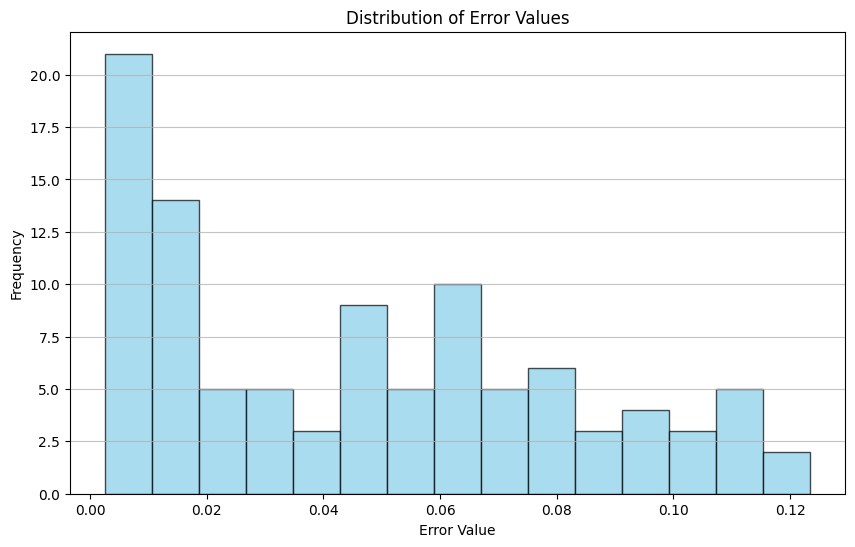

0.04641530405325192


In [12]:
errors = [results[0] for results in results]

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=15, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Error Values')
plt.xlabel('Error Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

print(np.mean(errors))